In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
import emcee
import corner

In [2]:
Dat=np.loadtxt('figure1_plotdata.csv',delimiter=',',skiprows=1)

In [ ]:
names=np.array(['b0','b1','b2','b3','b4'])

In [3]:
Bow= np.array([1500, 700,-1100,750,-175])             # intersección con el eje y
Cons=Bow

In [4]:
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables
# Datos cortados
x_C,y_C=Dat[:,0][Dat[:,0]>60.0] ,Dat[:,2][Dat[:,0]>60.0] # Variables
x_C,y_C=x_C[x_C<94.0],y_C[x_C<94.0]

In [306]:
def T_f(v,a0,a1,a2,a3,a4):
  vc=75.0 # frecuancia central (rean) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2


In [307]:
def log_like_mpv(theta,x,y,sigma):
  v=x
  a0,a1,a2,a3,a4 = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_f(v,a0,a1,a2,a3,a4))**2/sn2 + np.log(2*np.pi*sn2))

In [308]:
def T_mod_mpv(x,y,yerr,const):
  a0,a1,a2,a3,a4= const             # intersección con el eje y
  nll=lambda *args: -log_like_mpv(*args) # Construccion de la funcion lamda 
  v=x
  N=len(x) 
  vc=78.0
  #Condiciones iniciales
  In=const
  #Solución
  Sol=minimize(nll,In,args=(x, y, yerr))
  # Extrayendo los valores de los parametros arojados por MlE
  popt = Sol.x
#  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=popt

  return popt

In [309]:
Sol_mpv=T_mod_mpv(x_C,y_C,0.05,Cons[:5])
Sol_mpv

array([1916.60437113, -541.9381832 ,  646.53187206,  -78.5411885 ,
        -87.88840079])

Text(0, 0.5, '$T_\\mathrm{sky}$ (K)')

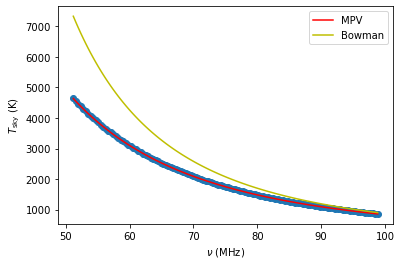

In [310]:
plt.scatter(x,y)
plt.plot(x,T_f(x,*Sol_mpv),c='r',label='MPV')
plt.plot(x,T_f(x,*Cons),c='y',label='Bowman')
plt.legend()
plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$T_\mathrm{sky}$ (K)')

In [387]:
def log_prob_mpv(theta, x, y):
    lp = log_p_mpv(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like_mpv(theta, x, y,0.025)
def log_p_mpv(theta):
  a0,a1,a2,a3,a4 = theta
#  if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0:
  if 1750 < a0 < 1800.0 and -160.0 < a1 < -120.0 and  -21.0< a2 < -13 and -9.5 <a3 < -8.8 and 0 < a4 < 11:
#  if 1750 < a0 < 1960.0 and -260.0 < a1 < -120.0 and  -25.0< a2 < -1 and -9.5 <a3 < -7.7 and 0 < a4 < 11:

    return 0.0
  return -np.inf   


In [375]:
def nwalk_mpv(x,y,Sol,walkers,steps):
  N=len(Sol)  
  pos = np.array(Sol)[:,np.newaxis]+ np.array(Sol)[:,np.newaxis]*1e-3*(np.random.randn(walkers, N) ).T # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  pos=pos.T  
  nwalkers, ndim = pos.shape  

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_mpv, args=(x, y))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler#discard=N, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params

In [400]:
steps=10000 #pasos
walkers=500
burn=100

In [401]:
Sol_forz=np.array([1755, -130 ,-18,-9,5])

In [402]:
Sol=Sol_forz
samples=nwalk_mpv(x,y,Sol,walkers,steps)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [05:09<00:00, 32.30it/s]


In [409]:
params=samples.get_chain(discard=1000, thin=100, flat=True)#parametros

In [410]:
params.shape

(45000, 5)

In [411]:
popt=np.array(params.mean(axis=0))

In [412]:
popt

array([ 1.76949811e+03, -1.59999996e+02, -1.30000479e+01, -8.80000074e+00,
        3.97544197e-06])

In [413]:
#params=params[0]

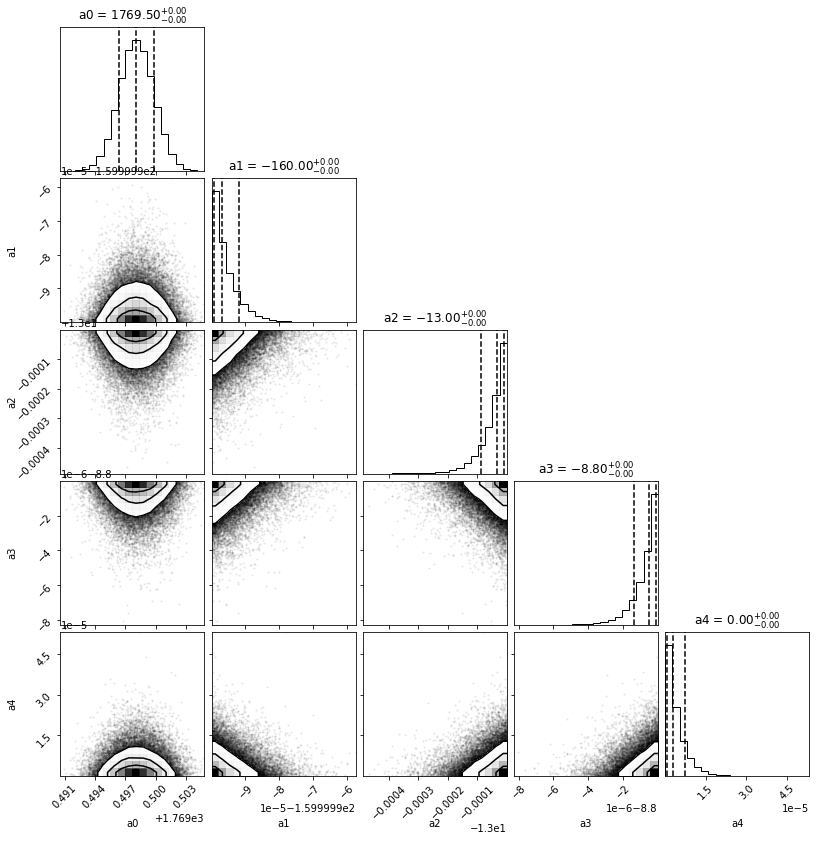

In [414]:
corner.corner(params,labels=names[:5],quantiles=[0.16, 0.5, 0.84],truths=Sol_mpv,show_titles=True)
plt.show()

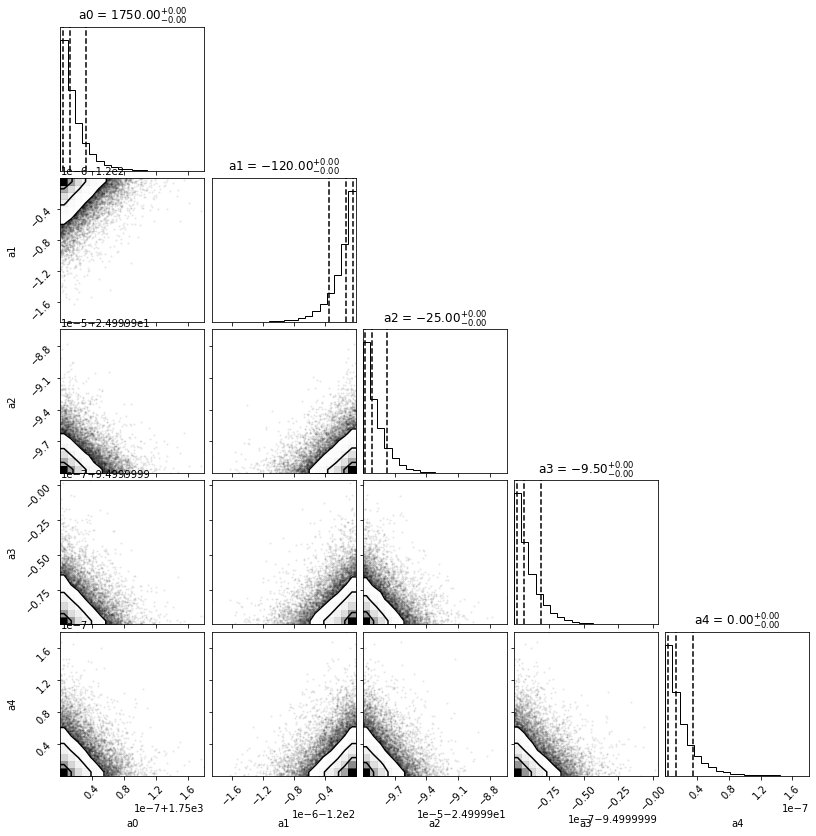

In [288]:
corner.corner(params,labels=names[:5],quantiles=[0.16, 0.5, 0.84],truths=Sol_mpv,show_titles=True)
plt.show()

In [289]:
pos = np.array(Sol)[:,np.newaxis]+ np.array(Sol)[:,np.newaxis]*1e-3 * (np.random.randn(walkers, N) ).T # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios

(array([  9.,  43., 194., 509., 701., 613., 313.,  95.,  19.,   4.]),
 array([1748.8471862 , 1750.14879991, 1751.45041362, 1752.75202734,
        1754.05364105, 1755.35525477, 1756.65686848, 1757.9584822 ,
        1759.26009591, 1760.56170963, 1761.86332334]),
 <a list of 10 Patch objects>)

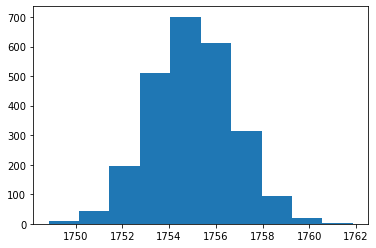

In [417]:
plt.hist(pos[0])

(array([1.3000e+01, 1.8300e+02, 1.2070e+03, 5.2220e+03, 1.1889e+04,
        1.3984e+04, 8.8660e+03, 3.0540e+03, 5.2800e+02, 5.4000e+01]),
 array([1769.49058965, 1769.49201414, 1769.49343863, 1769.49486312,
        1769.4962876 , 1769.49771209, 1769.49913658, 1769.50056107,
        1769.50198555, 1769.50341004, 1769.50483453]),
 <a list of 10 Patch objects>)

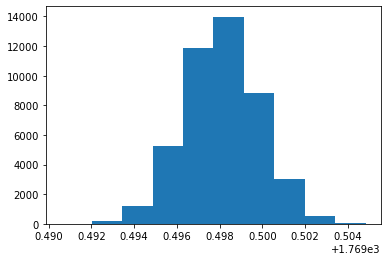

In [416]:
plt.hist(params[:,0])

In [385]:
popt

array([1759.99999659, -159.99999629,  -13.00003832,   -8.80000052,
          9.42058193])

Text(0, 0.5, '$T_\\mathrm{sky}$ (K)')

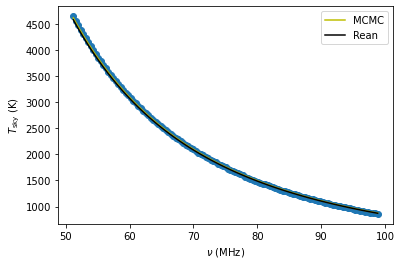

In [386]:
plt.scatter(x,y)
#plt.plot(x,T_f(x,*Sol_mpv),c='r',label='MPV')
plt.plot(x,T_f(x,*popt),c='y',label='MCMC')
plt.plot(x,T_f(x,*Sol_forz),c='k',label='Rean')

plt.legend()
plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$T_\mathrm{sky}$ (K)')

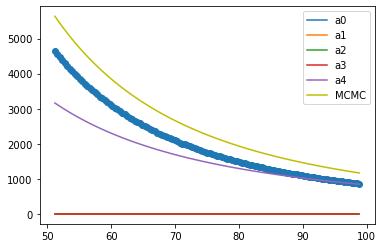

In [480]:
vc=75.0 # frecuancia central (EDGES) 
a0,a1,a2,a3,a4=popt
#popnew=np.array([ 1900.47027299,   70.13561551, -11.84228912,  -79.49207886,
#        -174.93551011])
#a0,a1,a2,a3,a4=popnew
plt.plot(x,a0*(x/vc)**-2.5,label="a0")
plt.plot(x,a1*(x/vc)**-2.5*np.log10(x/vc),label="a1")
plt.plot(x,a2*(x/vc)**-2.5*np.log10(x/vc)**2,label="a2")
plt.plot(x,a3*(x/vc)**-4.5,label="a3")
plt.plot(x,a4*(x/vc)**-2.0,label="a4")
plt.plot(x,T_f(x,*Sol_forz),c='y',label='MCMC')
plt.scatter(x,y)

plt.legend()


In [163]:
samps=10000
b0=np.random.uniform(1750,1760,samps)
b1=np.random.uniform(-0.087,-0.07,samps)
b2=np.random.uniform(-0.0144,-0.0110,samps)
b3=np.random.uniform(0.0050,0.0054,samps)
Te=np.random.uniform(0,2000,samps)

In [164]:
b4=b3*Te
a0=b0
a1=b0*b1
a2=b0*((b1**2)/2+b2)
a3=-b0*b3
a4=b4

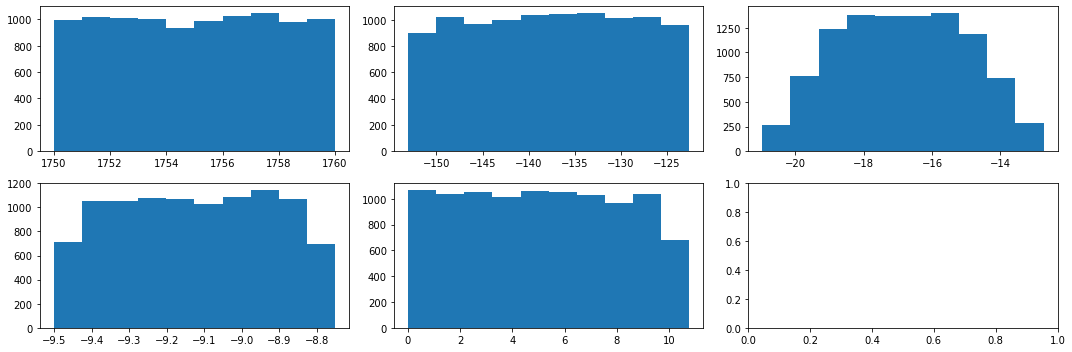

In [165]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))
axes[0,0].hist(a0)
axes[0,1].hist(a1)
axes[0,2].hist(a2)
axes[1,0].hist(a3)
axes[1,1].hist(a4)
fig.tight_layout()

In [418]:
def T_b(v,b0,b1,b2,b3,Te):
  vc=75.0 # frecuancia central (rean) 
  return (b0*(v/vc)**(-2.5+b1+b2*np.log10(v/vc)))*np.exp(-b3*(v/vc)**-2.0)+Te*(1-np.exp(-b3*(v/vc)**-2.0))

In [466]:
def log_like_b(theta,x,y,sigma):
  v=x
  b0,b1,b2,b3,Te = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_b(v,b0,b1,b2,b3,Te))**2/sn2 + np.log(2*np.pi*sn2))
def log_prob_b(theta, x, y):
    lp = log_p_b(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like_b(theta, x, y,0.025)
def log_p_b(theta):
  b0,b1,b2,b3,Te = theta
#  if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0:
  if 1750 < b0 < 1760.0 and -0.087 < b1 < -0.07 and  -0.1< b2 < 0.011 and 0.0050 <b3 < 0.2 and 200 < Te < 2000:
#  if 1750 < a0 < 1960.0 and -260.0 < a1 < -120.0 and  -25.0< a2 < -1 and -9.5 <a3 < -7.7 and 0 < a4 < 11:

    return 0.0
  return -np.inf  

In [467]:
def nwalk_b(x,y,Sol,walkers,steps):
  N=len(Sol)  
  pos = np.array(Sol)[:,np.newaxis]+ np.array(Sol)[:,np.newaxis]*1e-3*(np.random.randn(walkers, N) ).T # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  pos=pos.T  
  nwalkers, ndim = pos.shape  

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_b, args=(x, y))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler#discard=N, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params

In [468]:
steps=10000 #pasos
walkers=500
burn=100

In [469]:
Sol_forz=np.array([1755, -0.08 ,-0.012,0.0052,500])

In [470]:
Sol=Sol_forz
samples=nwalk_b(x,y,Sol,walkers,steps)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [04:53<00:00, 34.11it/s]


In [477]:
params=samples.get_chain(discard=4000, thin=100, flat=True)#parametros
params.shape

(30000, 5)

In [478]:
popt=np.array(params.mean(axis=0))

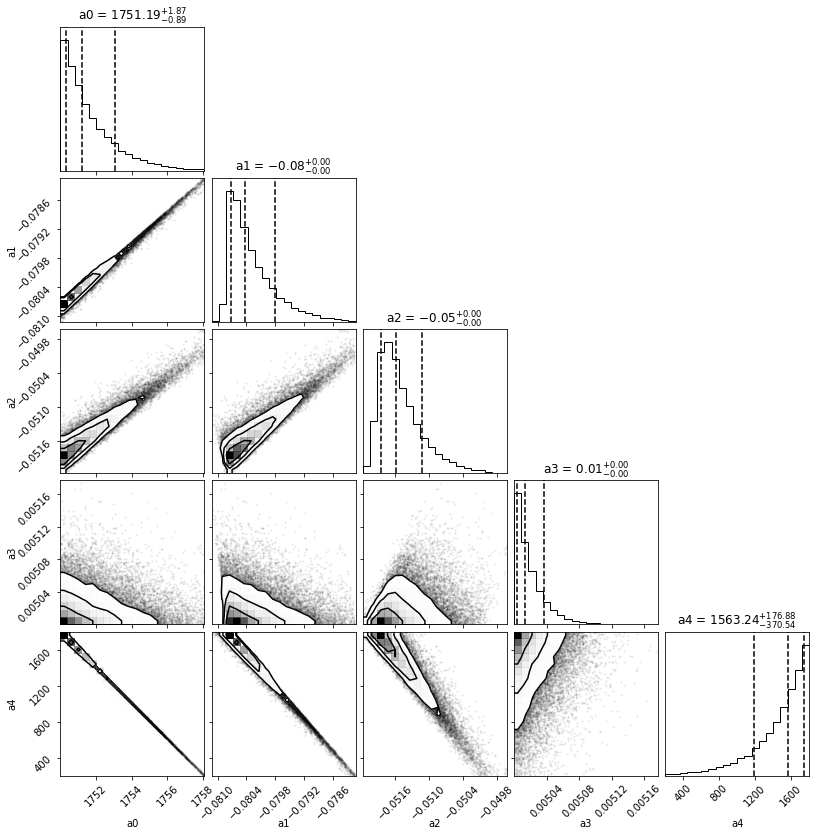

In [479]:
corner.corner(params,labels=names[:5],quantiles=[0.16, 0.5, 0.84],truths=Sol_mpv,show_titles=True)
plt.show()

Text(0, 0.5, '$T_\\mathrm{sky}$ (K)')

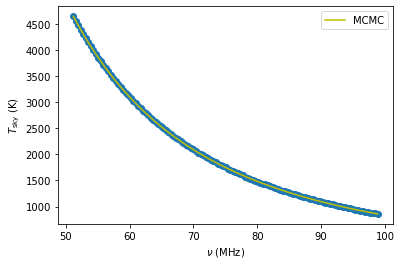

In [481]:
plt.scatter(x,y)
#plt.plot(x,T_f(x,*Sol_mpv),c='r',label='MPV')
plt.plot(x,T_b(x,*popt),c='y',label='MCMC')
#plt.plot(x,T_b(x,*Sol_forz),c='k',label='Rean')

plt.legend()
plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$T_\mathrm{sky}$ (K)')

In [485]:
popt

array([ 1.75165060e+03, -8.02795363e-02, -5.14892547e-02,  5.01970472e-03,
        1.47218521e+03])

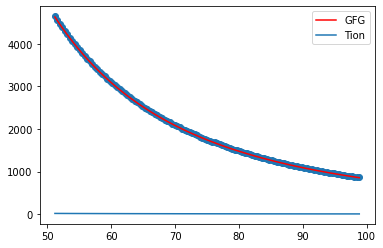

In [488]:
vc=75.0 # frecuancia central (EDGES) 
b0,b1,b2,b3,Te=popt
#popnew=np.array([ 1900.47027299,   70.13561551, -11.84228912,  -79.49207886,
#        -174.93551011])
#a0,a1,a2,a3,a4=popnew
v=x
plt.plot(x,(b0*(v/vc)**(-2.5+b1+b2*np.log10(v/vc)))*np.exp(-b3*(v/vc)**-2.0),label="GFG",c='r')
plt.plot(x,Te*(1-np.exp(-b3*(v/vc)**-2.0)),label="Tion")
#plt.plot(x,T_b(x,*popt),c='y',label='MCMC')
plt.scatter(x,y)

plt.legend()

In [ ]:
Te

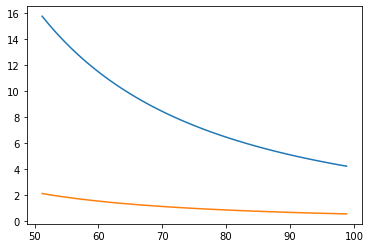

In [486]:
plt.plot(x,Te*(1-np.exp(-b3*(v/vc)**-2.0)),label="Tion")
plt.plot(x,200*(1-np.exp(-b3*(v/vc)**-2.0)),label="Tion")


(array([3.1873e+04, 9.3500e+03, 2.7220e+03, 7.5200e+02, 2.1100e+02,
        6.1000e+01, 2.5000e+01, 4.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-0.0144    , -0.01439976, -0.01439953, -0.01439929, -0.01439905,
        -0.01439882, -0.01439858, -0.01439834, -0.0143981 , -0.01439787,
        -0.01439763]),
 <a list of 10 Patch objects>)

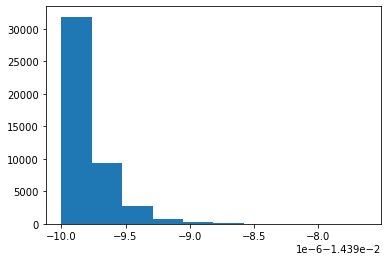

In [464]:
plt.hist(params[:,2])

In [465]:
popt

array([ 1.75817143e+03, -7.56346780e-02, -1.43998084e-02,  5.39996626e-03,
        2.00162128e+02])